# 1. Discussion of Results

In this section, we investigated how to deal with missing data and imbalanced data. We performed this investigation using single trees, and used the insights gleaned to guide our approaches in our use of ensembles. The ensembles we used are random forests and gradient boosted trees. Below, we provide a discussion of the results while highlighting the challenges we faced and possible extensions.

## 1.1. Imbalance
The imbalance in the data was challenging to deal with, and our models had very low precisions, meaning that they had difficulty to identify high income individuals accurately. Many low-income individuals had a tendency to be predicted as high-income because they were male. Using SMOTE did not help much with this, as we saw we only got a marginal increase in the area under the ROC curve after using SMOTE. In fact, the original paper on SMOTE (see [1]) suggests combining SMOTE with an undersampling technique on the majority class to obtain better results, as the synthetic samples only considered the minority class. This is something we could explore, as indeed the precision was poor.

## 1.2. Missingness
The investigation using single trees was surprising to us. The different methods of dealing with missingness led to very similar test performance. We did not compare the methods using ensembles as the burden of computation was too high. Even if we had time and computational power, it would be tricky to investigate surrogate splits as they are not natively supported in `scikit-learn` or `R` packages implementing random forests and gradient boosted trees, as far as we could find.

Mode imputation seemed to be a strong method to deal with missingness. However, there is a possible issue with mode imputation for the missing occupation values. The imputation has a chance to be totally wrong, and therefore this can bias our results. We would recommend changing this value to a numerical ordered factor and attempt to redo an imputation based on the ordered factor. This would be slightly more robust, as we can have a better chance of getting `close' to the true value instead of having a chance of being totally off. Also, for further robustness, it would be useful to use multiple imputation. Due to limitations in time and computational power, we could not recode the occupations as ordered factors nor use multiple imputation. This therefore remains a way the models can be extended.

Alternatively, we can use a Bayesian model. This provides a way to deal with missing data in a probabilistic framework (see [3] for details). Markov chain Monte Carlo methods can be used to fit the model, using software such as JAGS [4] or Stan [5]. If this turns out to be complicated or time-consuming, integrated nested Laplace approximations (INLA) provide a way to do fast approximate Bayesian inference using Laplace approximations. This has an implementation in R [6]. This has natural in-built ways to deal with missingness.

## 1.3. Tuning
Tuning the random forest and gradient boosted trees was challenging. There was a large number of parameters, and therefore there was a large space to optimise over. To overcome this challenge, we used randomised grid search with cross-validation. This can be extended by using an exhaustive search instead, and defining a finer grid. It may also be of interest to look at sophisticated methods of optimisation, such as the use of tree-structured Parzen estimators (see [2]), which use a Bayesian method and a cheaper to evaluate loss function to perform optimisation. Such methods have good empirical results in the literature [2], and can be an extension to our project.

## 1.4. Choice of Test Set
We chose the test set such that it only had complete data. This may have biased our results, though it is difficult to tell. It may be worth to repeat an analysis using a totally random split stratified by sex, without ensuring the test set has complete data. It may be worth to also check other choices of split and average the results to get a more robust view of the performance, especially if the models have to be deployed for downstream tasks. 

# 2. Choice of Model

To choose between the tree-based models, we will use the ROC curve to compare their performances.

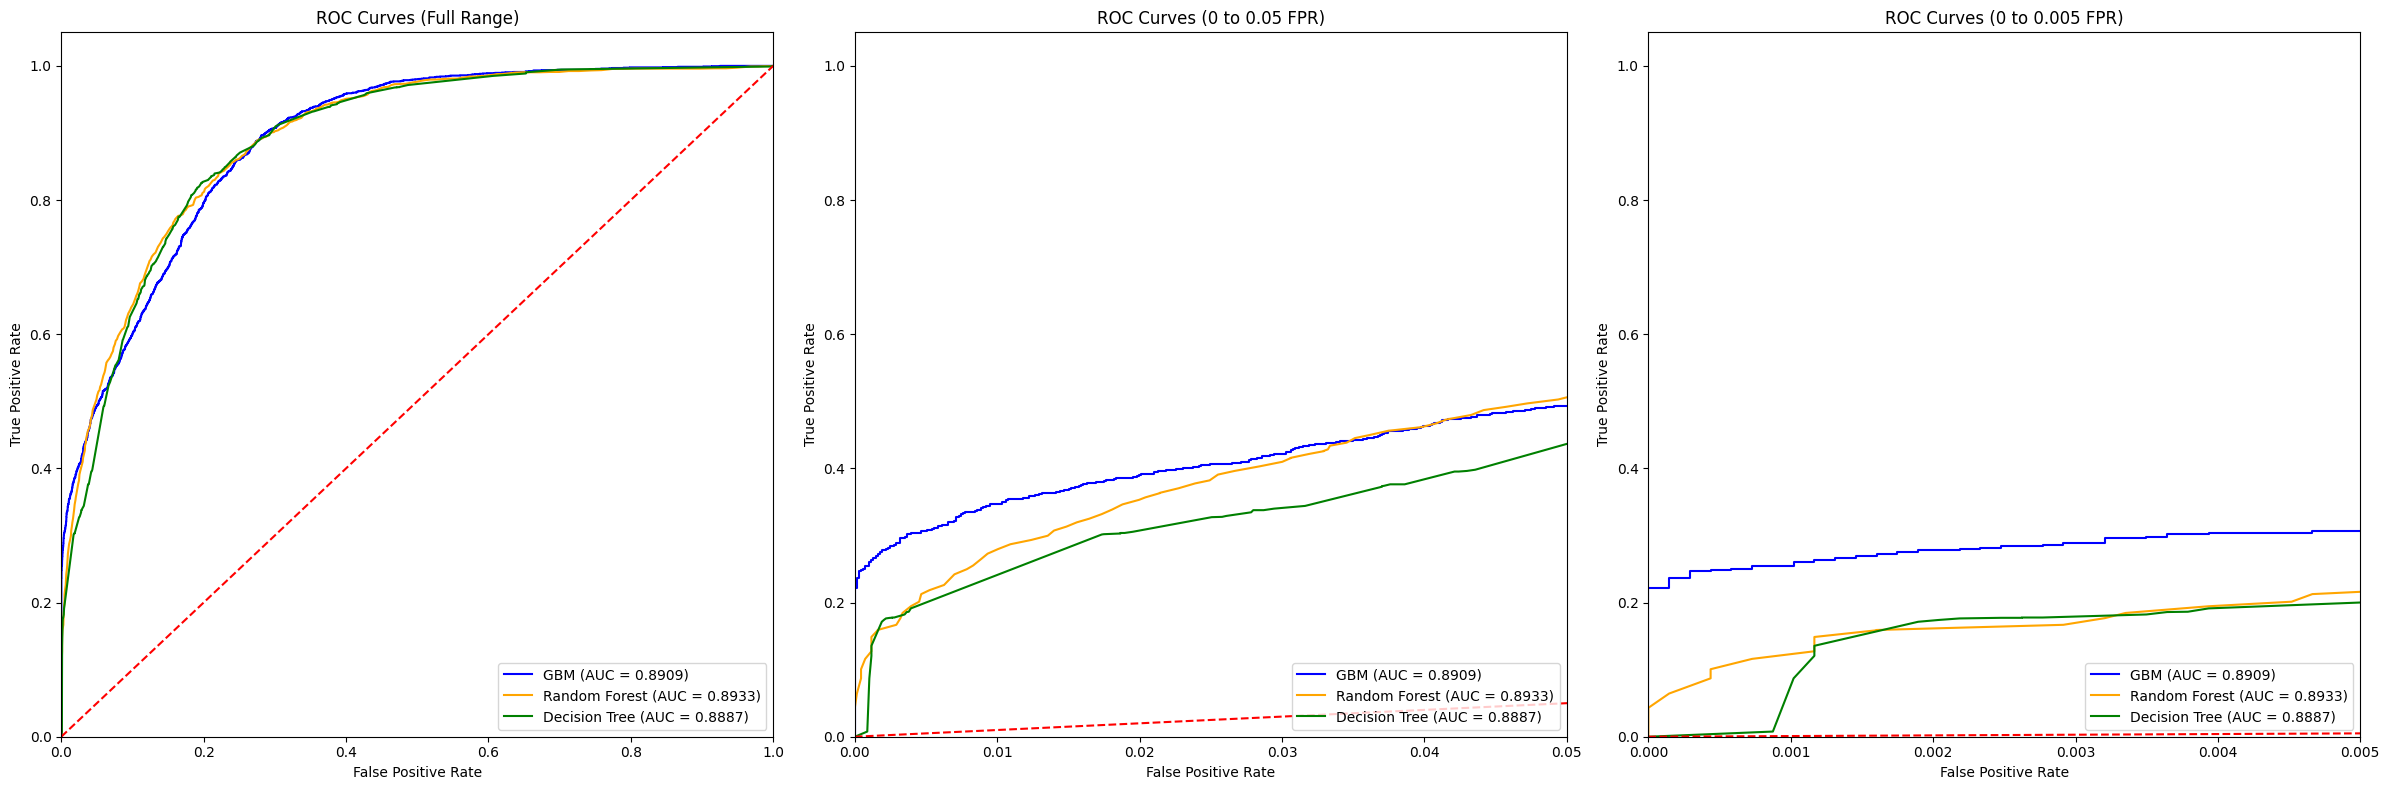

In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Load ROC data for Gradient Boosting Machine (GBM) and Random Forest (RF)
with open("pickle/gbm_roc_data.pkl", 'rb') as file:
    gbm_roc_data = pickle.load(file)
with open("pickle/rf_roc_data.pkl", 'rb') as file:
    rf_roc_data = pickle.load(file)

# Load ROC data from CSV for Decision Tree (DT)
tree_roc_data = pd.read_csv("roc_data/roc_data_smote_imputed.csv")

# Define a function to plot ROC curves on specified axis and x-axis range
def plot_roc(ax, xlim, title):
    ax.plot(gbm_roc_data['fpr'], gbm_roc_data['tpr'], color='blue', 
            label=f'GBM (AUC = {gbm_roc_data["roc_auc"]:.4f})')
    ax.plot(rf_roc_data['fpr'], rf_roc_data['tpr'], color='orange', 
            label=f'Random Forest (AUC = {rf_roc_data["roc_auc"]:.4f})')
    ax.plot(tree_roc_data['FPR'], tree_roc_data['TPR'], color='green', 
            label=f'Decision Tree (AUC = {tree_roc_data["AUC"].mean():.4f})')
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random guessing diagonal
    ax.set_xlim(xlim)
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(False)

# Create subplots: full range, small range (0-0.05), very small range (0-0.005)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot using the helper function for different x-axis ranges
plot_roc(ax1, [0.0, 1.0], 'ROC Curves (Full Range)')
plot_roc(ax2, [0.0, 0.05], 'ROC Curves (0 to 0.05 FPR)')
plot_roc(ax3, [0.0, 0.005], 'ROC Curves (0 to 0.005 FPR)')

# Show the plots
plt.tight_layout()
plt.show()


We make several observations:
- The gradient boosted machine dominates the other classifiers for very low false positive rates (FPR) in the range 0 to 0.005. 
- Overall, the random forest has the highest AUC.
- The single tree performs worst for FPRs from 0.01 to 0.05 and for FPRs less than 0.001. 
- All models have the same AUC to 2 decimal places. In particular, the performance of the ensembles was overall a little disappointing as the AUC was the same as that for a single tree (to 2 d.p.). 

We will choose between the models based on the area under the ROC curve. This leads us to choose the random forest.

We believe this is a reasonable choice based on what we have seen in Section 5.3. We recall that our question is to understand the variation of the proportion of high income individuals by sex. The random forest predicted the proportions for females very accurately, as shown by the last bar plot in the Section 5.3.1. 

However, a limitation of this model is that the area under the ROC curve was 0.8933. This is a number with room for improvement. We can see especially that precision is very low. The extensions mentioned above, regarding tuning and handling of missing data, can help us get a better performing model.


# 3. Conclusion

In Section 5, we have investigated tree-based methods. We first used single trees as a means to investigate ways to deal with missingness and imbalance with relative computational ease. We saw that the method of mode imputation showed promise in dealing with missingness (which only occurred in categorical covariates). However, as we have discussed above, using multiple imputation or recoding the occupations as numerical factors could help us get more reliable conclusions. Imbalance was a difficult issue to contend with. SMOTE did not give us any major performance boosts in terms of AUC. The extensions mentioned in Part 1.1 (Imbalance) of this document can help with overcoming this.

Once we had obtained an understanding of how to deal with missingness and imbalance, we went to consider ensemble methods. These are a state-of-the-art method for classification and are highly praised in the literature [7]. However, we were slightly disillusioned in this case, as the AUC ended up the same as for single trees (to 2 decimal places). As mentioned in Part 1.3 (Tuning) of this document, tuning was challenging for these models due to the high amount of computation needed. A finer grid search which is non-randomized can possibly help us.

In conclusion, the random forest model shows the most promise in analyzing income variation by sex as it had the highest area under the ROC curve. However, it still has several limitations. We should focus on improving its precision. Implementing proposed extensions will be crucial for achieving better predictive accuracy. This will ultimately help us gain deeper insights into income disparities across different demographic groups.


# 4. References

[1] Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002): 321-357.

[2] Ozaki, Yoshihiko, et al. "Multiobjective tree-structured parzen estimator for computationally expensive optimization problems." Proceedings of the 2020 genetic and evolutionary computation conference. 2020.

[3] Ma, Zhihua, and Guanghui Chen. "Bayesian methods for dealing with missing data problems." Journal of the Korean Statistical Society 47 (2018): 297-313.

[4] Plummer, Martyn. "JAGS Version 3.3. 0 user manual." (2012): 40.

[5] Carpenter, Bob, et al. "Stan: A probabilistic programming language." Journal of statistical software 76 (2017): 1-32.

[6] Rue, Håvard, et al. "Bayesian computing with INLA: a review." Annual Review of Statistics and Its Application 4.1 (2017): 395-421.

[7] Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. "The elements of statistical learning: data mining, inference, and prediction." (2017).